# Entendiendo Pipelines, Models y Schedulers

*Es notebook es una adaptación de:* https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline

El *DiffusionPipeline* integra *Models* y *Schedulers* para proporcionar facilidad de uso. Sin embargo, también es posible evitar el uso de *pipelines* y orquestar modelos y *schedulers* de forma para crear nuevos sistemas de difusión.

Este notebook explora como combinar modelos y *schedulers* para crear desde un pipeline de inferencia muy sencilla, a otro más avanzado.

## Deconstruyendo un pipeline básico

El uso de un *pipeline* es la forma más rápida de realizar inferencia utilizando la librería *diffusers*. Requiere solo unas pocas líneas de código.

In [1]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")
image = ddpm(num_inference_steps=25).images[0]
image

model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

OSError: Could not find the necessary `safetensors` weights in {'diffusion_pytorch_model.bin', 'diffusion_pytorch_model.safetensors'} (variant=None)

Echemos un vistazo ahora a lo que hace pipeline bajo la superficie de su llamada. El pipeline anterior utiliza un modelo *UNet2DModel* y un planificador *DDPMScheduler*. El pipeline le quita el ruido a una imagen, partiendo de una imagen con ruido aleatorio, las dimensiones deseadas de la salida y pasando la entrada por el modelo varias veces. En casa paso, el modelo predice ruido residual (*noise residual*) y el planificador lo utiliza para generar una imagen menos ruidosa. El pipeline repite este proceso un número de pasos predefinido. 

Creemos ahora un pipeline similar pero orquestando explícitamente el modelo y el planificador.

In [2]:
from diffusers import DDPMScheduler, UNet2DModel

#Instancia el modelo y el scheduler
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")
# Configura el número de pasos del scheduler
scheduler.set_timesteps(50)
# Esto generará un array de 50 timesteps separados por la misma cantidad de tiempo
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

Continuemos ahora creando una imagen con la misma dimensión que la salida deseada pero que contenga ruido aleatorio.

In [3]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

Ahora, creememos un bucle que itere sobre los timesteps generados en el scheduler. En cada iteración, hacemos la pasada foward del modelo, la cual recibe el ruido residual. Luego, el step del *scheduler* toma la entrada, el timestep y el ruido residual y genera la imagen en el paso de tiempo previo. 

El proceso se repite iterativamente utilizando la nueva imagen generada por el scheduler como la entrada en la siguiente iteración del bucle.

In [5]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

Finalmente, se convierte la salida (*input*) tras la última iteración del proceso en una imagen.

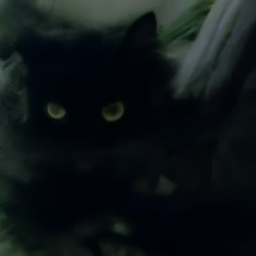

In [6]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

## Deconstruyendo el pipeline de Stable Diffusion

El siguiente reto es recrear el pipeline de Stable Diffusion, que es un modelo de difusión mucho más complejo. *Stable Diffusion* es un model *latent diffusion* de generación de imágenes a partir de un *prompt* de texto. El término *latent diffusion* hace referencia a que trabaja con una representación de la imagen de baja dimensionalidad en vez de con el espacio de pixeles real, reduciendo así su consumo de memoria. Un codificador (*encoder*) comprime la imagen en una representación más pequeña, mientras que decodificador (*decoder*) devuelve la imagen a su representación original. Además, al ser un imagen que usa texto como entrada, necesita un *tokenizer* y un *encoder* para generar los *embeddings* del texto. Esto conjunto, formado por tres modelos, es más complejo que el modelo UNet en el que se basaba el pipeline anterior (DDPM). 

Los tres componentes del modelo actual se van a cargar con la función *from_pretrained()* a partir de checkpoints de un mismo modelo. Los modelos suelen tener cada componente en subdirectorio distinto.

In [28]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

Es muy fácil utilizar un *scheduler* diferente.

In [29]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

También es sencillo mover los componentes del sistema a un dispositivo Cuda para acelerar la inferencia.

In [32]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

## Creación de un *embedding* de texto

El siguiente paso es tokenizar el texto para la generación de sus correspondientes *embeddings*. El texto se usa para condicionar el modelo *UNet* y encaminar el proceso de difusión hacia algo que responde al *prompt* de entrada.

El parámetro *guidance_scale* especifica cuánto paso se debería dar al *prompt* cuando se genera una imagen.

In [30]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

Ahora procesa el texto del prompt (*tokenize*+*embedding*)

In [33]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

También, es neceario generar los *unconditional text embeddings* que son aquellos utilizados como tokens de relleno. Estos necesitan tener la misma dimensionalidad (*batch_size* y *seq_length*) que los *text_embeddings* condicionales.

In [6]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

Ahora reunimos los *conditional* y *unconditional* *text embeddings* en un único *batch* para evitar tener que hacer la pasada *forward* dos veces.

In [7]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

### Creación del ruido aleatorio

A continuación, creamos ruido aleatorio para generar el punto de partida del proceso de difusión. Este es la representación latente de la imagen que será gradualmente *denoised*. En este punto, la imagen latente es más pequeña que el tamaño final de la imagen generada, pero eso es correcto por que el modelo la transformará al tamaño adecuado (512x512) más adelante. En concreto,  la anchura y altura de la imagen son dividias por 8 a la entrada.

In [35]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device="cpu",
)


### Denoising de la imagen

Comenzamos escalando la entrada con la distribución de ruido inicial, *sigma*, el valor de la escala de ruido, el cual es requido para planificadores mejorados como *UniPCMultistepScheduler*.

In [36]:
latents = latents * scheduler.init_noise_sigma

El último paso es la creación del bucle de *denoising* que transformará progresivamente el ruido puro en los latentes de un imagen que responda al *prompt* de entrada. Recordemos que el bucle de *denoising* requiere.

1. Fijar los *timesteps* del *scheduler* usado durante el proceso de *denoising*.
2. Iterar sobre esos *timesteps*.
3. En cada paso de tiempo, llama al modelo *UNet* para predecir el ruido residual y pásaselo al *scheduler* para calcular el *sample* ruidos anterior.

In [39]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)
unet.to(torch_device)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    latent_model_input = latent_model_input.to(torch_device)
    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (8192) must match the size of tensor b (4096) at non-singleton dimension 1

### Decodificación de la imagen

El último paso es usar el *vae* para decodificar la representación latente en una iamgen completa y generar así la salida decodificada con *sample*.


In [40]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Converiet la imagen a un formato de imagen    
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)